# TODO

- ~~noisy~~
- optimalizace diskretnich hyperparam - https://arxiv.org/pdf/1706.03673.pdf

- benchmark + proc approx?
- paralelni
- expected imrpovement per second (vetsi hyperaram me stoji vic trenovani)
- v prubehu zjistim

- kernely
- acquisition funkce

- matern kernel wtf???
- zkusit jestli torch.lbfgs je rychlejsi?

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from numpy.linalg import solve, cholesky, inv
from numpy.random import multivariate_normal

from functools import partial

%matplotlib inline

from myopt.kernels import SquaredExp, RationalQuadratic, Linear
from myopt.gaussian_process import GaussianProcess, compute_optimized_kernel
from myopt.bayesian_optimization import bo_minimize
from myopt.acquisition_functions import expected_improvement
from myopt.bayesian_optimization import propose_location

In the basic form we have $K = k(X_{\text{train}}, X_{\text{train}}), K_* = k(X_{\text{train}}, X_{\text{test}}), K_{**} = k(X_{\text{test}}, X_{\text{test}})$, which gives us the following posterior

$$
\begin{align}
    \mu &= K_* K^{-1} y \\
    var &= K_{**} - K_* K^{-1} K_*^T.
\end{align}
$$

We can also write

$$
\begin{align}
    L &= cholesky(K) \\
    \alpha &= L^T \backslash (L \backslash y) \\
    \mu &= K_*^T \alpha \\
    v &= L \backslash K_* \\
    var &= K_{**} - v^T v,
\end{align}
$$

and we also know that

$$
(L \backslash K_*)^T (L \backslash y) = K_*^T (L^T \backslash (L \backslash y)) = K_* K^{-1} y
$$

## GP regression (ignoring noisy for now)

We condition on the training data and compute the posterior for the test data $X_{\text{test}}$. Since the posterior is Gaussian, it is fully defined by its mean and covariance, which we can compute in closed form

$$
\begin{align}
    \mu_* &= K_*^T K_*^{-1} y \\
    \Sigma_* &= K_{**} - K_*^T K_*^{-1} K_*
\end{align}
$$

In [3]:
X_train = np.array([0, 0.3, 2, 4])
y_train = np.sin(X_train)

X = np.arange(min(X_train) - 0.5, max(X_train) + 0.5, step=0.1)

SquaredExp(l=1, sigma=1)
RationalQuadratic(sigma=1, l=1, alpha=1)


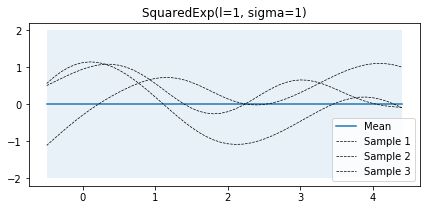

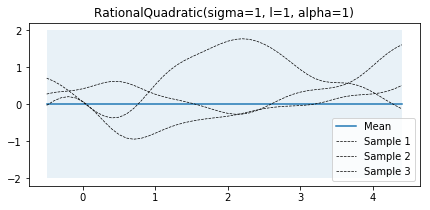

In [4]:
for k in [SquaredExp(), RationalQuadratic()]: #, Linear()]:
    print(k)
    GaussianProcess(kernel=k).plot_prior(X)

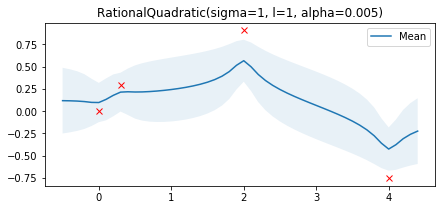

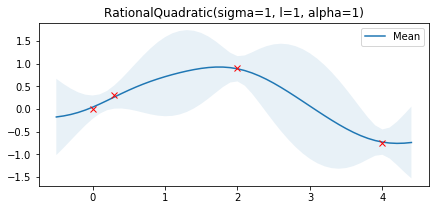

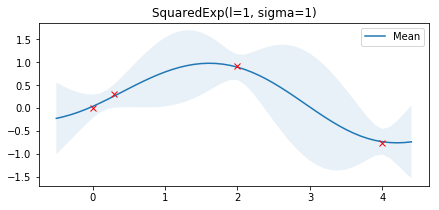

In [5]:
for kernel in [RationalQuadratic(alpha=0.005), RationalQuadratic(), SquaredExp()]: #, Linear()]:
    GaussianProcess(kernel=kernel).with_noise(.02)\
        .posterior(X, X_train, y_train).plot_posterior(num_samples=0)

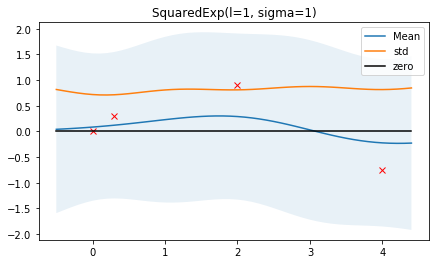

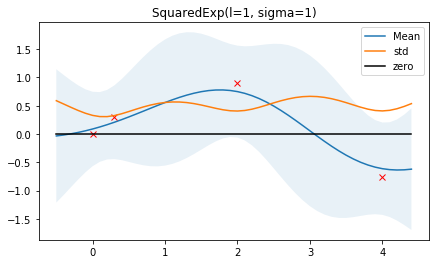

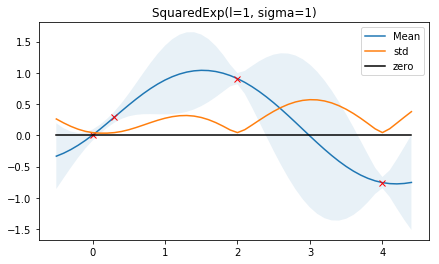

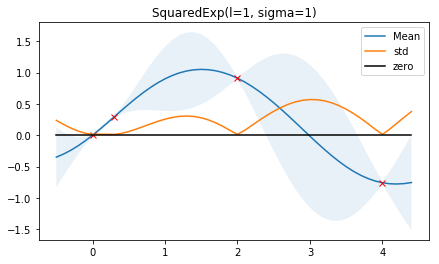

In [6]:
for noise in [2, 0.2, 0.002, 0.0002]:
    gp = GaussianProcess().with_noise(noise).posterior(X, X_train, y_train)
    plt.figure(figsize=(7,4))
    gp.plot_posterior(num_samples=0, figure=False)
    plt.plot(X, np.sqrt(np.diag(gp.cov)), label="std")
    plt.plot(X, np.zeros_like(X), label="zero", c="k")
    plt.legend()
    plt.show()

## Kernel params

Found optimal params [1.11880499 1.24381089]


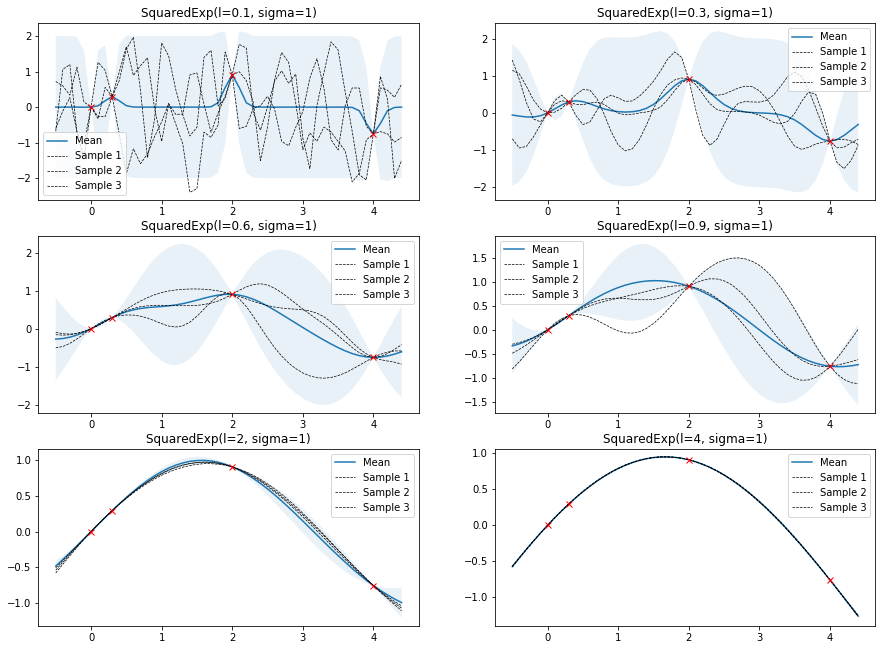

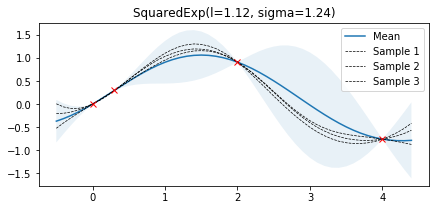

In [7]:
params = [0.1, 0.3, 0.6, 0.9, 2, 4]

gp = GaussianProcess()

plt.figure(figsize=(15,15))
for i, l in enumerate(params):
    num_rows = len(params) // 2 + 1

    plt.subplot(num_rows, 2, i+1)
    
    gp.with_kernel_params([l, 1]).fit(X_train, y_train).posterior(X).plot_posterior(figure=False)

gp.fit(X_train, y_train).optimize_kernel().posterior(X).plot_posterior()

## Optimizing kernel parameters

$$
\begin{align}
    \log p(y|X) &= \log N(y|0, K_y) \\
                &= -\frac{1}{2} y^T K_y^{-1} y - \frac{1}{2} \log |K_y| - \frac{N}{2} \log(2 \pi)
\end{align}
$$

SquaredExp(l=2, sigma=1)

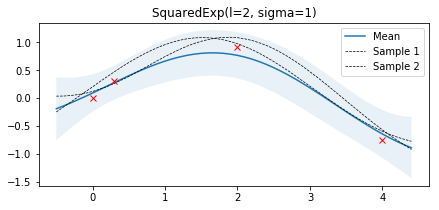

In [8]:
GaussianProcess(.05).fit(X_train, y_train)\
        .with_kernel_params([2, 1]).posterior(X).plot_posterior(num_samples=2).kernel

Found optimal params [1.11880499 1.24381089]


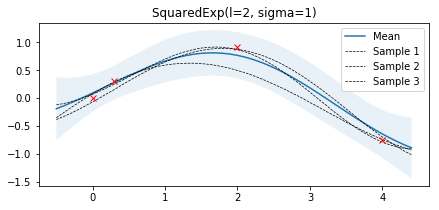

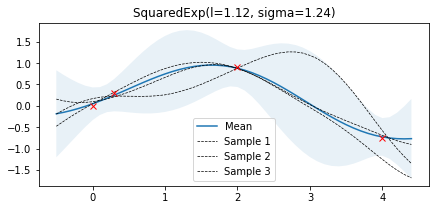

In [9]:
GaussianProcess(.05).fit(X_train, y_train)\
        .with_kernel_params([2, 1]).posterior(X).plot_posterior()\
        .optimize_kernel().posterior(X).plot_posterior()

## More general alternative to `np.meshgrid`

In [10]:
a = np.array([1,2]).reshape(-1, 1)
b = np.array([4,5]).reshape(1, -1)

a + b

array([[5, 6],
       [6, 7]])

In [11]:
a * b

array([[ 4,  5],
       [ 8, 10]])

## but how do I do this with tensordot on tensors?

In [12]:
a = np.array([[1,0],[2,0]]).reshape(-1, 1, 2)
b = np.array([[4,0],[5,0]]).reshape(1, -1, 2)

In [13]:
np.sqrt(((a - b) ** 2).sum(axis=2))

array([[3., 4.],
       [2., 3.]])

In [14]:
np.linalg.norm(a - b, axis=2)

array([[3., 4.],
       [2., 3.]])

In [15]:
np.tensordot(a, b, axes=2)

array([[4, 0],
       [8, 0]])

In [16]:
# This seems to work, but why are there the extra dimensions?
np.tensordot(a, b, axes=[2,2])

array([[[[ 4,  5]]],


       [[[ 8, 10]]]])

In [17]:
np.tensordot(a, b, axes=((1, 2), (0, 2)))

array([[ 4,  5],
       [ 8, 10]])

In [18]:
z = np.zeros((a.shape[0], b.shape[1]))

for i in range(a.shape[0]):
    for j in range(b.shape[1]): 
        z[i, j] = a[i, 0] @ b[0, j]

z

array([[ 4.,  5.],
       [ 8., 10.]])

In [19]:
a = np.array([[1,0],[2,0]]).reshape(-1, 1, 2)
b = np.array([[4,0],[5,0]]).reshape(1, -1, 2)

za = np.zeros_like(a)
zb = np.zeros_like(b)

aa = a + zb
bb = b + za

np.tensordot(aa, bb, axes=((1,2), (0,2)))
# array([[ 8,  0],
#        [16,  0]])

array([[ 8, 10],
       [16, 20]])

## Workaround with one loop

In [20]:
a = np.array([[1,0],[2,0]])
b = np.array([[4,0],[5,0]])

bb = b.T

rows = []

for i in range(a.shape[0]):
    rows.append(a[i] @ bb)

res = np.array(rows)

In [21]:
np.array(rows)

array([[ 4,  5],
       [ 8, 10]])

# Bayesian Optimization

http://krasserm.github.io/2018/03/21/bayesian-optimization/

In [22]:
bounds = np.array([[-1.0, 2.0]])
noise = 0.2

def f(X):
    return -np.sin(3*X) - X**2 + 0.7*X

X_init = np.array([[-0.9], [1.1]])
y_init = f(X_init)

# Dense grid of points within bounds
X_true = np.arange(bounds[:, 0], bounds[:, 1], 0.01).reshape(-1, 1)

# Noise-free objective function values at X 
y_true = f(X_true)

Found optimal params [1.75666023 0.94885863]
Found optimal params [0.50237525 1.10153685]
Found optimal params [0.49783616 1.07653041]
Found optimal params [0.10797361 1.02773858]
Found optimal params [0.47611826 1.34933255]
Found optimal params [0.50109773 1.78539964]
Found optimal params [0.43644007 1.6610477 ]
Found optimal params [0.49375388 2.30810373]
Found optimal params [0.89263582 6.72349276]
Found optimal params [0.92834036 9.58710749]
Found optimal params [ 0.9545107 13.3579261]
Found optimal params [ 0.97776605 18.12094679]
Found optimal params [ 0.99435386 23.57144198]
Found optimal params [ 1.00472199 31.51961788]
Found optimal params [ 0.89204019 24.532631  ]
Found optimal params [ 0.80431297 26.48949085]
Found optimal params [ 0.86679826 38.91575181]
Found optimal params [ 1.03809124 89.28558022]
Found optimal params [  1.03118239 111.61866263]
Found optimal params [  1.02163729 138.93680445]


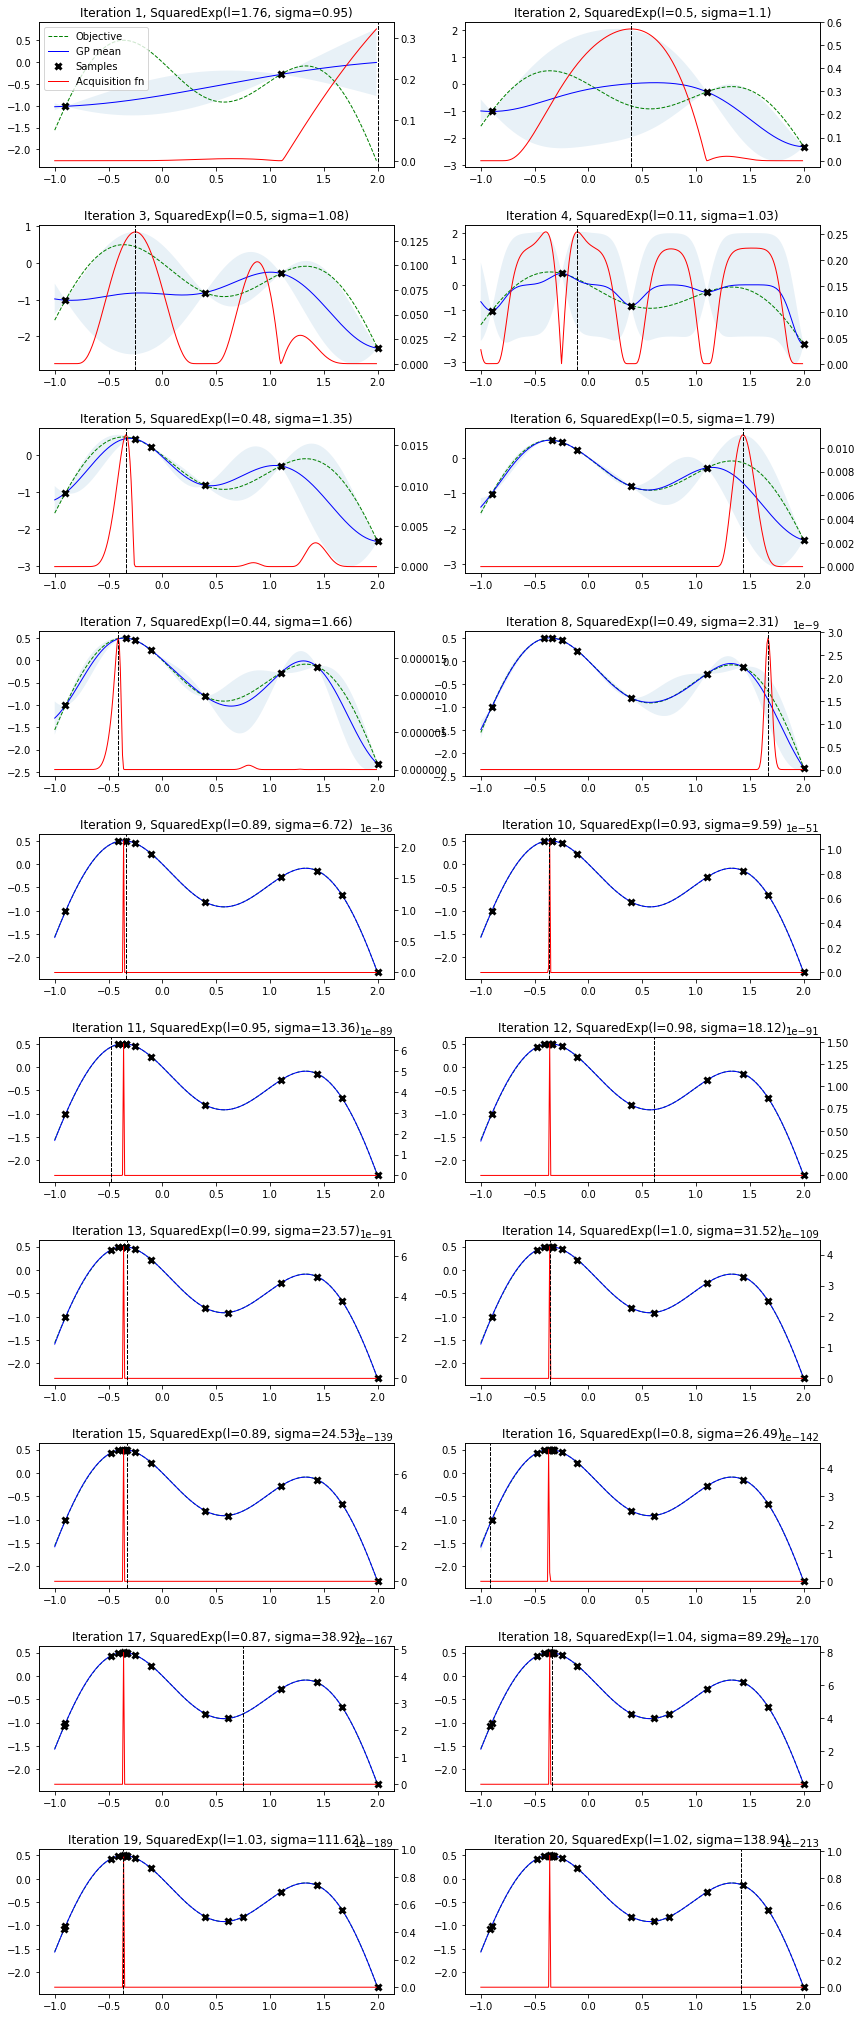

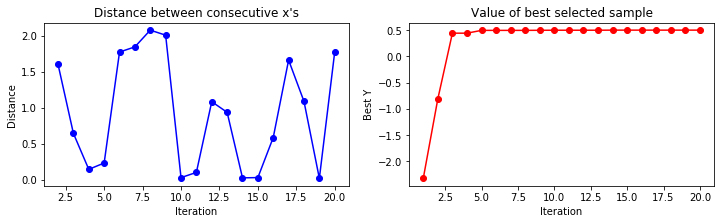

In [23]:
bo_minimize(lambda x: f(x) + np.random.randn(1)*0.001, bounds, X_init, y_init, X_true=X_true, y_true=y_true, n_iter=20)

Found optimal params [1.75666023 0.94885863]
Found optimal params [0.50251924 1.10136543]
Found optimal params [0.49792367 1.07642452]
Found optimal params [0.11157408 1.02763691]
Found optimal params [0.47676467 1.34631771]
Found optimal params [0.50167853 1.78238297]
Found optimal params [0.43700859 1.65849972]
Found optimal params [0.49393666 2.30479608]
Found optimal params [0.85921715 6.3617732 ]
Found optimal params [0.90533924 9.29831544]
Found optimal params [ 0.93827099 13.22183054]
Found optimal params [ 0.9609443  18.41527028]
Found optimal params [ 0.99503729 24.15582478]
Found optimal params [ 1.00544967 32.16082749]
Found optimal params [ 1.01509883 41.50072765]
Found optimal params [ 0.77801399 24.53315269]
Found optimal params [ 1.02754595 70.25508731]
Found optimal params [ 1.01204774 83.8890373 ]
Found optimal params [  0.98802115 102.0817077 ]
Found optimal params [  1.03524024 138.05708153]
 

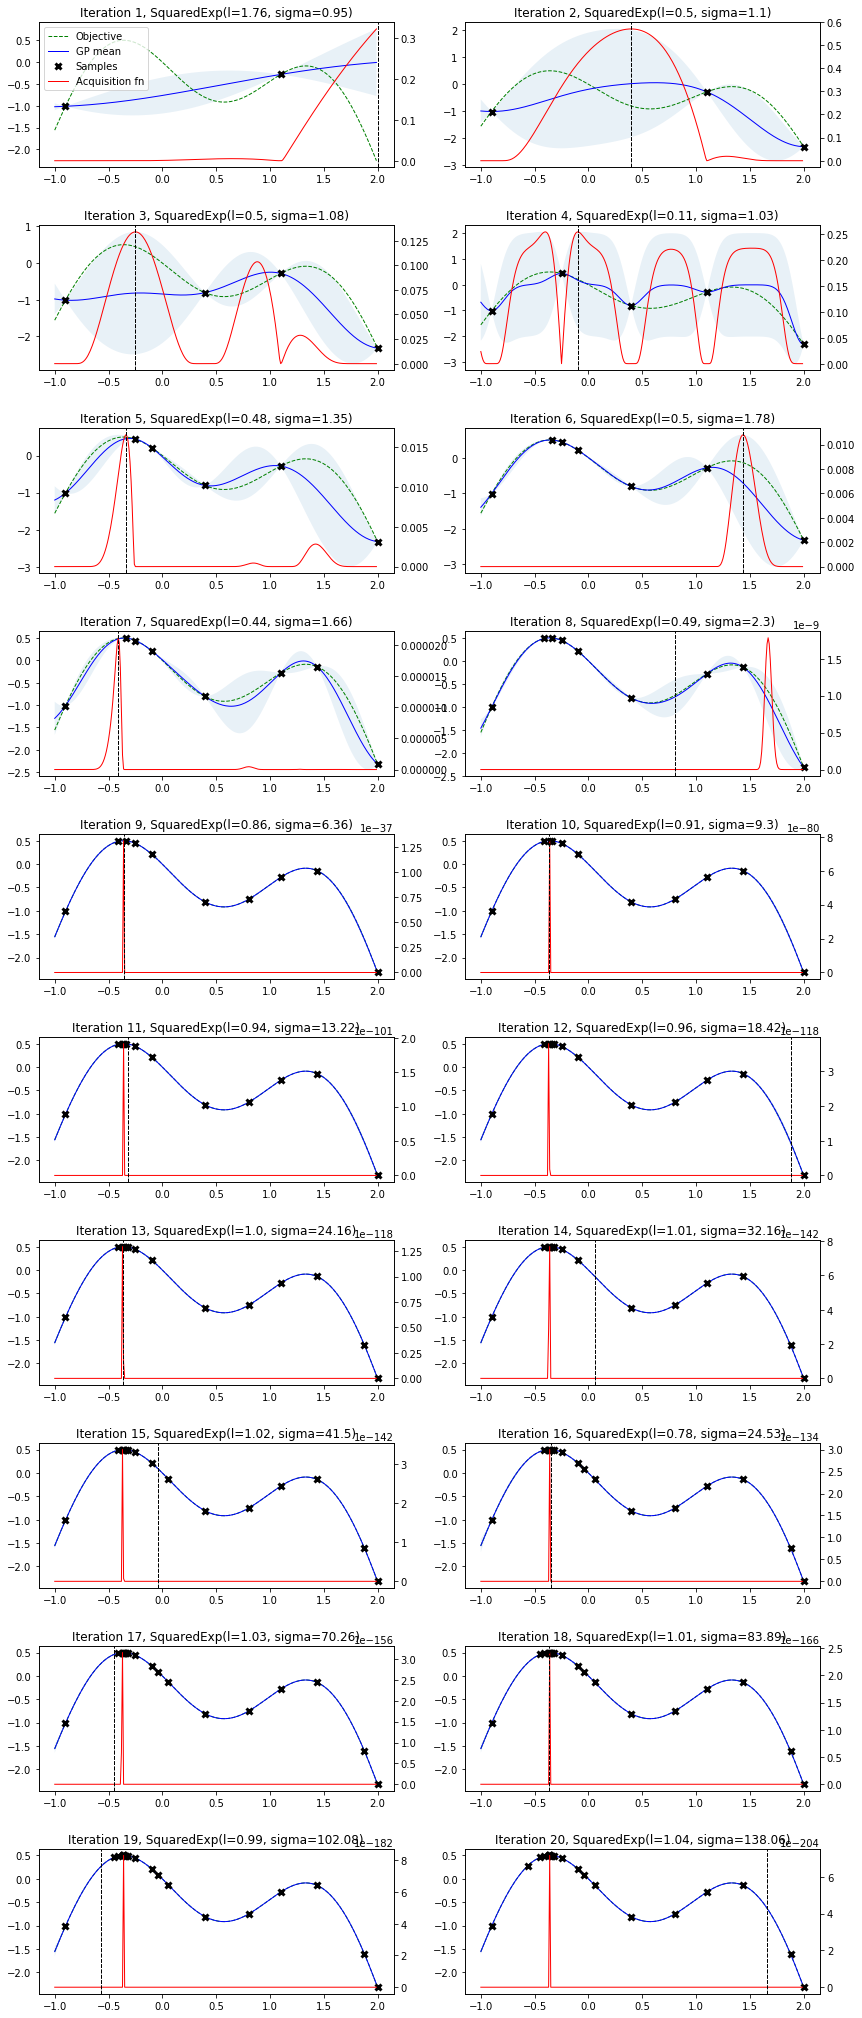

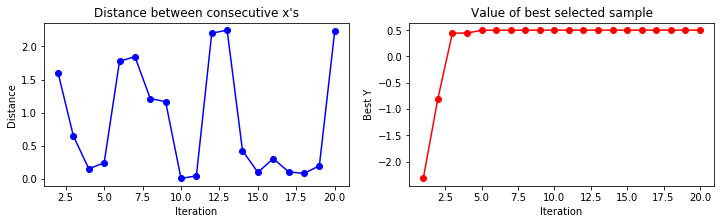

In [25]:
bo_minimize(f, bounds, X_init, y_init, X_true=X_true, y_true=y_true, n_iter=20, optimize_kernel=True)

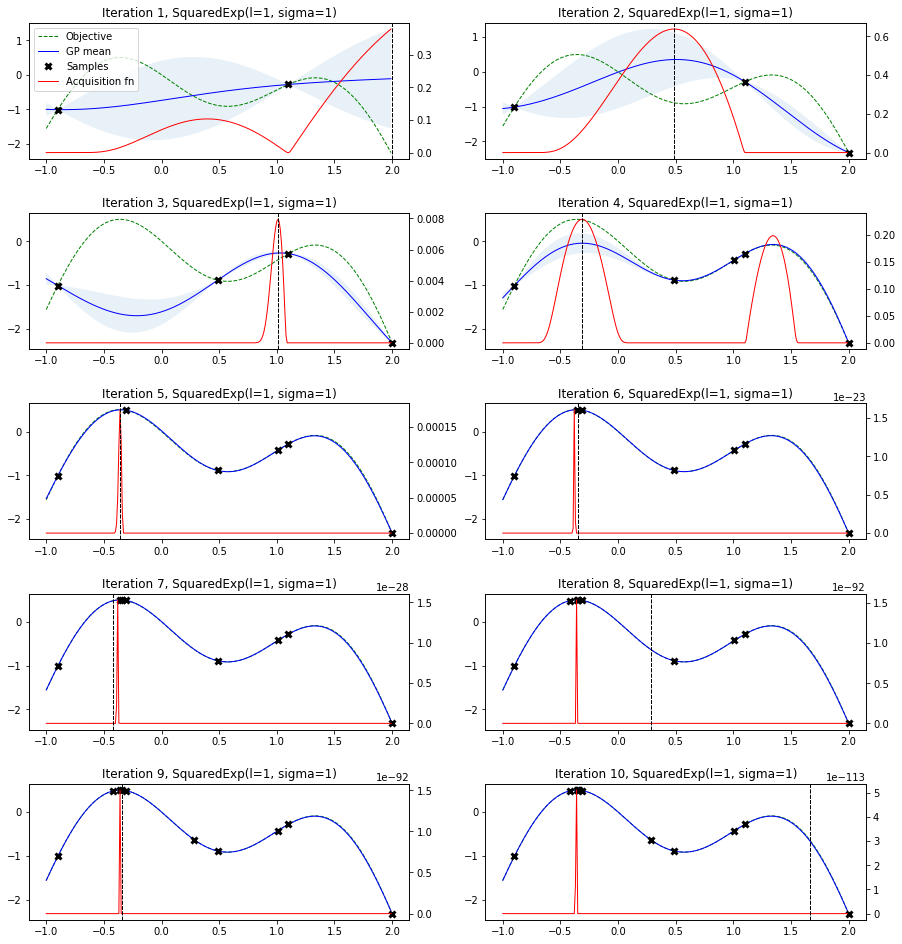

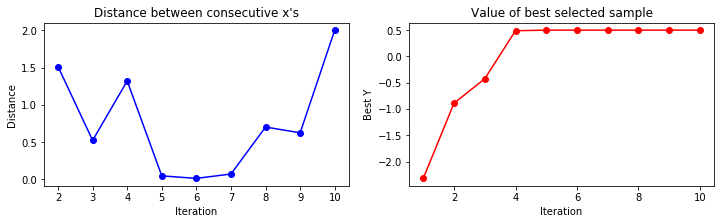

In [30]:
bo_minimize(f, bounds, X_init, y_init, X_true=X_true, y_true=y_true, n_iter=10, optimize_kernel=False)

# Matrix inverse timing

- zkompilovat numpy s AVX

In [33]:
import torch

In [34]:
for n in [10, 100, 1000, 2000, 3000, 4000]:
    m = np.random.randn(n, n)
    %time inv(m)

Wall time: 0 ns
Wall time: 499 µs
Wall time: 41.4 ms
Wall time: 255 ms
Wall time: 782 ms
Wall time: 1.79 s


In [35]:
for n in [10, 100, 1000, 2000, 3000, 4000]:
    m = torch.from_numpy(np.random.randn(n, n))
    %time torch.inverse(m)

Wall time: 9.98 ms
Wall time: 14 ms
Wall time: 27 ms
Wall time: 167 ms
Wall time: 510 ms
Wall time: 1.04 s


In [36]:
for n in [10, 100, 1000, 2000, 3000, 4000]:
    m = torch.from_numpy(np.random.randn(n, n)).cuda()
    %time torch.inverse(m)

Wall time: 926 ms
Wall time: 23.9 ms
Wall time: 63.4 ms
Wall time: 151 ms
Wall time: 340 ms
Wall time: 569 ms


In [38]:
%time torch.inverse(m)

Wall time: 591 ms


tensor([[ 0.0009, -0.0053, -0.0049,  ...,  0.0061,  0.0065,  0.0053],
        [-0.0095,  0.0046, -0.0253,  ...,  0.0103, -0.0010,  0.0084],
        [-0.0068,  0.0011,  0.0201,  ..., -0.0129, -0.0010, -0.0013],
        ...,
        [-0.0037, -0.0003, -0.0476,  ...,  0.0214, -0.0037,  0.0027],
        [ 0.0447, -0.0389, -0.0729,  ...,  0.0066, -0.0096, -0.0238],
        [ 0.0326, -0.0234, -0.0391,  ...,  0.0067, -0.0060, -0.0150]],
       device='cuda:0', dtype=torch.float64)

## GP benchmarks

In [ ]:
noise = 0.2

# Noisy training data
X_train = 400*np.random.rand(100) - 200
y_train = np.sin(X_train) + noise * np.random.randn(*X_train.shape)


X = np.arange(-200, 200, 0.2)
%prun GaussianProcess().fit(X_train, y_train).optimize_kernel().posterior(X).plot_posterior(num_samples=2)


In [ ]:
noise = 0.2

# Noisy training data
X_train = 400*np.random.rand(100) - 200
y_train = np.sin(X_train) + noise * np.random.randn(*X_train.shape)


X = np.arange(-200, 200, 0.2)
%time GaussianProcess().fit(X_train, y_train).posterior(X).plot_posterior(num_samples=2)

X = np.arange(-200, 200, 0.1)
%time GaussianProcess().fit(X_train, y_train).posterior(X).plot_posterior(num_samples=2)

In [ ]:
import numpy as np
from numpy.linalg import inv

for n in [10, 100, 1000, 2000, 3000, 4000]:
    m = np.random.randn(n, n)
    %time inv(m)

In [ ]:
import torch

for n in [10, 100, 1000, 2000, 3000, 4000]:
    m = torch.from_numpy(np.random.randn(n, n))
    %time torch.inverse(m)

## 2D bayes opt

In [ ]:
X_2d

In [ ]:
from myopt.plot import plot_gp_2D
from mpl_toolkits.mplot3d import axes3d, Axes3D

noise_2d = 0.01

rx, ry = np.arange(-5, 5, 0.3), np.arange(-5, 5, 0.3)
gx, gy = np.meshgrid(rx, rx)

X_2d = np.c_[gx.ravel(), gy.ravel()]

X_2d_train = np.random.uniform(-4, 4, (150, 2))
y_2d_train = np.sin(0.5 * np.linalg.norm(X_2d_train, axis=1))# + noise_2d * np.random.randn(len(X_2d_train))

mu_s, _ = GaussianProcess().fit(X_2d_train, y_2d_train).optimize_kernel().posterior(X_2d).mu_std()

plt.figure(figsize=(12, 4))
plt.subplot(121); plt.title("GP posterior");
plt.imshow(mu_s.reshape(gx.shape[0], gy.shape[0]))

plt.subplot(122); plt.title("True F");
plt.imshow(np.sin(0.5 * np.linalg.norm(X_2d, axis=1)).reshape(gx.shape[0], gy.shape[0]))

In [ ]:
from myopt.plot import plot_gp_2D
from mpl_toolkits.mplot3d import axes3d, Axes3D

noise_2d = 0.01

rx, ry = np.arange(-5, 5, 0.3), np.arange(-5, 5, 0.3)
gx, gy = np.meshgrid(rx, rx)

X_2d = np.c_[gx.ravel(), gy.ravel()]

X_2d_train = np.random.uniform(-4, 4, (50, 2))
y_2d_train = np.sin(0.5 * np.linalg.norm(X_2d_train, axis=1))# + noise_2d * np.random.randn(len(X_2d_train))

# plt.figure(figsize=(14,7))

# mu_s, _ = GaussianProcess().fit(X_2d_train, y_2d_train).posterior(X_2d).mu_std()

#plot_gp_2D(gx, gy, mu_s, X_2d_train, y_2d_train, "LOL it works", 1)
#plt.show()

mu_s, _ = GaussianProcess().fit(X_2d_train, y_2d_train).optimize_kernel().posterior(X_2d).mu_std()

plt.figure(figsize=(13,8))
plot_gp_2D(gx, gy, mu_s, X_2d_train, y_2d_train, "w/ kernel optt", 1)

plt.figure(figsize=(12, 4))
plt.subplot(121); plt.title("GP posterior"); plt.imshow(mu_s.reshape(gx.shape[0], gy.shape[0]))
plt.subplot(122); plt.title("True F"); plt.imshow(np.sin(0.5 * np.linalg.norm(X_2d, axis=1)).reshape(gx.shape[0], gy.shape[0]))

#%matplotlib inline
# mu_s, _ = posterior_predictive(X_2D, X_2D_train, Y_2D_train, sigma_y=noise_2D)
# plot_gp_2D(gx, gy, mu_s, X_2D_train, Y_2D_train, 
#            f'Before parameter optimization: l={1.00} sigma_f={1.00}', 1)

# res = minimize(nll_fn(X_2D_train, Y_2D_train, noise_2D), [1, 1], 
#                bounds=((1e-5, None), (1e-5, None)),
#                method='L-BFGS-B')

# mu_s, _ = posterior_predictive(X_2D, X_2D_train, Y_2D_train, *res.x, sigma_y=noise_2D)
# plot_gp_2D(gx, gy, mu_s, X_2D_train, Y_2D_train,
#            f'After parameter optimization: l={res.x[0]:.2f} sigma_f={res.x[1]:.2f}', 2)

In [ ]:
rx, ry = np.arange(-5, 5, 0.3), np.arange(-5, 5, 0.3)
gx, gy = np.meshgrid(rx, rx)

X_2d = np.c_[gx.ravel(), gy.ravel()]

X_2d_train = np.random.uniform(-4, 4, (100, 2))
y_2d_train = np.sin(0.5 * np.linalg.norm(X_2d_train, axis=1)) + \
             noise_2d * np.random.randn(len(X_2d_train))